<a href="https://colab.research.google.com/github/Lospaspas/DataScienceUNAB/blob/main/TRABAJO_FINAL_UNAB_LAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Cargar los datos y preprocesamiento
data = pd.read_csv('dataset_elpino.csv', sep=';')

# Función para extraer código antes del guion
def extract_code(value):
    if isinstance(value, str) and '-' in value:
        return value.split('-')[0].strip()
    return value

data.replace('-', pd.NA, inplace=True)
data.dropna(inplace=True)

# Aplicar la función de extracción de códigos
data_codigos = data.apply(lambda col: col.map(extract_code))

# Renombrar columnas a nombres descriptivos
nombres_diagnosticos = [f'diagnostico_{i}' for i in range(1, 36)]
nombres_procedimientos = [f'procedimiento_{i}' for i in range(1, 31)]
otras_columnas = ['edad', 'genero', 'GRD']  # Ajustamos el nombre correcto de la columna GRD

# Mapeo de nombres de columnas
data_codigos.columns = nombres_diagnosticos + nombres_procedimientos + otras_columnas

# Codificación de diagnósticos y procedimientos como números
le_diagnostico = LabelEncoder()
le_procedimiento = LabelEncoder()
le_grd = LabelEncoder()

for col in nombres_diagnosticos:
    data_codigos[col] = le_diagnostico.fit_transform(data_codigos[col])

for col in nombres_procedimientos:
    data_codigos[col] = le_procedimiento.fit_transform(data_codigos[col])

# Codificación de la columna GRD
data_codigos['GRD'] = le_grd.fit_transform(data_codigos['GRD'])

# Normalizar las columnas de edad (opcional)
scaler = StandardScaler()
data_codigos['edad'] = scaler.fit_transform(data_codigos[['edad']])

vocab_size_diagnostico = data_codigos[nombres_diagnosticos].max().max() + 1
vocab_size_procedimiento = data_codigos[nombres_procedimientos].max().max() + 1
num_classes = len(le_grd.classes_)

# Crear secuencias de entrada y etiquetas
secuencias = data_codigos[nombres_diagnosticos + nombres_procedimientos].values
etiquetas = data_codigos['GRD'].values

# Balanceo de clases
grd_distribution = data_codigos['GRD'].value_counts()  # Aquí usamos 'data_codigos' que contiene 'GRD'

# Realizamos un submuestreo menos agresivo (500 ejemplos por clase mayoritaria)
majority_class_size = 500
data_majority = data_codigos[data_codigos['GRD'].isin(grd_distribution[grd_distribution > majority_class_size].index)]
data_minority = data_codigos[data_codigos['GRD'].isin(grd_distribution[grd_distribution <= majority_class_size].index)]

# Submuestreo de las clases mayoritarias
data_majority_balanced = data_majority.groupby('GRD').apply(lambda x: x.sample(majority_class_size)).reset_index(drop=True)

# Combinamos con las clases minoritarias sin alterarlas
data_balanced = pd.concat([data_majority_balanced, data_minority])

# Actualizar secuencias y etiquetas con los datos balanceados
secuencias = data_balanced[nombres_diagnosticos + nombres_procedimientos].values
etiquetas = data_balanced['GRD'].values

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(secuencias, etiquetas, test_size=0.3, random_state=42)

# Dataset y DataLoader
class GRDDataset(Dataset):
    def __init__(self, secuencias, etiquetas):
        self.secuencias = secuencias
        self.etiquetas = etiquetas

    def __len__(self):
        return len(self.secuencias)

    def __getitem__(self, idx):
        secuencia = torch.tensor(self.secuencias[idx], dtype=torch.long)
        etiqueta = torch.tensor(self.etiquetas[idx], dtype=torch.long)
        return secuencia, etiqueta

train_dataset = GRDDataset(X_train, y_train)
test_dataset = GRDDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Aumentamos el batch size
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modelo con LSTM mejorado con batch normalization
class GRDLSTM(nn.Module):
    def __init__(self, vocab_size_diagnostico, vocab_size_procedimiento, emb_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(GRDLSTM, self).__init__()
        self.diagnostico_embedding = nn.Embedding(vocab_size_diagnostico, emb_dim)
        self.procedimiento_embedding = nn.Embedding(vocab_size_procedimiento, emb_dim)

        # LSTM con menos capas para evitar el sobreajuste
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, dropout=dropout)

        # Fully connected layers con batch normalization
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Añadimos BatchNorm
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)  # BatchNorm para la segunda capa fully connected
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        diag_input = x[:, :35]
        proc_input = x[:, 35:]

        diag_embedded = self.diagnostico_embedding(diag_input)
        proc_embedded = self.procedimiento_embedding(proc_input)

        # Concatenar las secuencias
        embedded = torch.cat((diag_embedded, proc_embedded), dim=1)

        # Pasar por LSTM con menos capas
        lstm_out, (hn, cn) = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Tomar la última salida de la secuencia

        # Fully connected con Batch Normalization y Dropout
        lstm_out = self.dropout(self.relu(self.bn1(self.fc1(lstm_out))))
        lstm_out = self.dropout(self.relu(self.bn2(self.fc2(lstm_out))))
        output = self.fc3(lstm_out)
        return output

# Crear el modelo
model = GRDLSTM(vocab_size_diagnostico, vocab_size_procedimiento, emb_dim=128, hidden_dim=256, num_layers=2, num_classes=num_classes, dropout=0.6)

# Optimización y entrenamiento
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)  # Aumentamos la tasa de aprendizaje
loss_fn = nn.CrossEntropyLoss()

# Scheduler
total_steps = len(train_dataloader) * 30
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Entrenamiento
num_epochs = 30
best_f1 = 0.0  # Variable para guardar el mejor F1-score

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        secuencias, etiquetas = batch
        secuencias, etiquetas = secuencias.to(device), etiquetas.to(device)

        optimizer.zero_grad()
        outputs = model(secuencias)
        loss = loss_fn(outputs, etiquetas)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader):.4f}')

    # Evaluación en el conjunto de validación
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_dataloader:
            secuencias, etiquetas = batch
            secuencias, etiquetas = secuencias.to(device), etiquetas.to(device)
            outputs = model(secuencias)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(etiquetas.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calcular el F1-score ponderado
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'F1-Score del modelo en los datos de prueba: {f1:.4f}')

    # Guardar el mejor modelo basado en el F1-score
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Mejor modelo guardado con F1-Score: {best_f1:.4f}')

# Cargar el mejor modelo guardado después del entrenamiento
model.load_state_dict(torch.load('best_model.pth'))

# Evaluación final del mejor modelo
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        secuencias, etiquetas = batch
        secuencias, etiquetas = secuencias.to(device), etiquetas.to(device)
        outputs = model(secuencias)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(etiquetas.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular la precisión final y el F1-score ponderado
accuracy = accuracy_score(y_true, y_pred)
f1_final = f1_score(y_true, y_pred, average='weighted')
print(f'Precisión final del modelo: {accuracy:.4f}')
print(f'F1-Score final del modelo: {f1_final:.4f}')

<ipython-input-4-5c3c8e70ff21>:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_majority_balanced = data_majority.groupby('GRD').apply(lambda x: x.sample(majority_class_size)).reset_index(drop=True)


Epoch 1/30, Loss: 2.4000
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 2/30, Loss: 2.2867
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 3/30, Loss: 2.3355
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 4/30, Loss: 2.3411
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 5/30, Loss: 2.2673
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 6/30, Loss: 2.2516
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 7/30, Loss: 2.1194
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 8/30, Loss: 1.8757
F1-Score del modelo en los datos de prueba: 0.0000
Epoch 9/30, Loss: 1.7775
F1-Score del modelo en los datos de prueba: 0.1397
Mejor modelo guardado con F1-Score: 0.1397
Epoch 10/30, Loss: 1.7278
F1-Score del modelo en los datos de prueba: 0.1323
Epoch 11/30, Loss: 1.8973
F1-Score del modelo en los datos de prueba: 0.1278
Epoch 12/30, Loss: 1.8544
F1-Score del modelo en los datos de prueba: 0.1296
Epoch 13/30, Loss: 1.7933
F1-Score del mod

<ipython-input-4-5c3c8e70ff21>:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<ipython-input-5-fde645624655>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_majority_balanced = data_majority.groupby('GRD', group_keys=False).apply(lambda x: x.sample(majority_class_size))


Epoch 1/30, Loss: 2.8299, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 2/30, Loss: 2.7266, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 3/30, Loss: 2.5308, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 4/30, Loss: 2.5904, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 5/30, Loss: 2.4651, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 6/30, Loss: 2.3819, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 7/30, Loss: 2.6152, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 8/30, Loss: 2.3287, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 9/30, Loss: 2.4650, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 10/30, Loss: 2.3946, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 11/30, Loss: 2.3729, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 12/30, Loss: 2.2132, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 13/30, Loss: 2.2431, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 14/30, Loss: 2.1350, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 15/30, Loss: 2.3083, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 16/30, Loss: 2.2862, F1-Score: 0.0000, Accuracy: 0.0000
Epoch 17/30, Loss

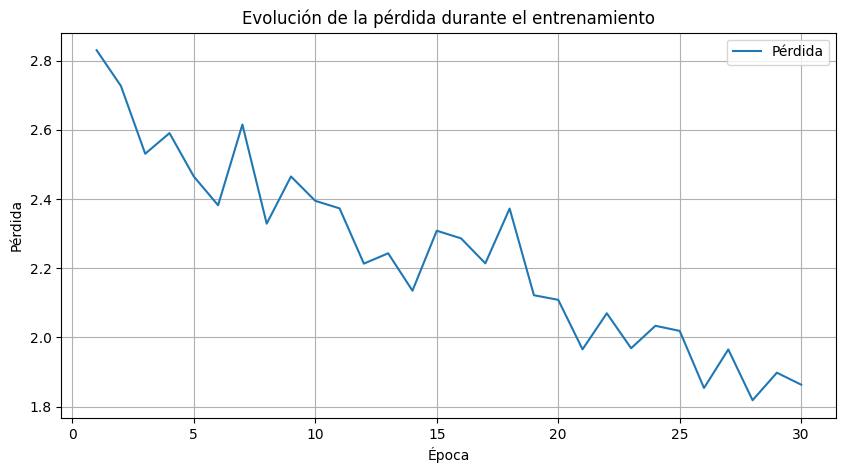

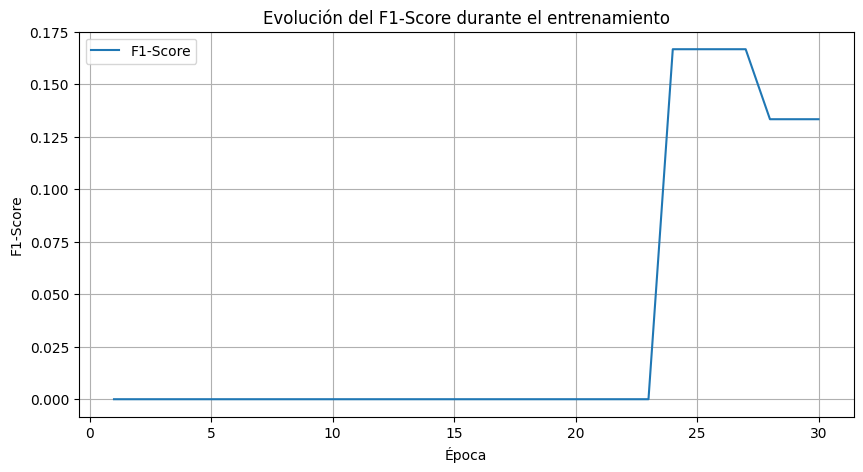

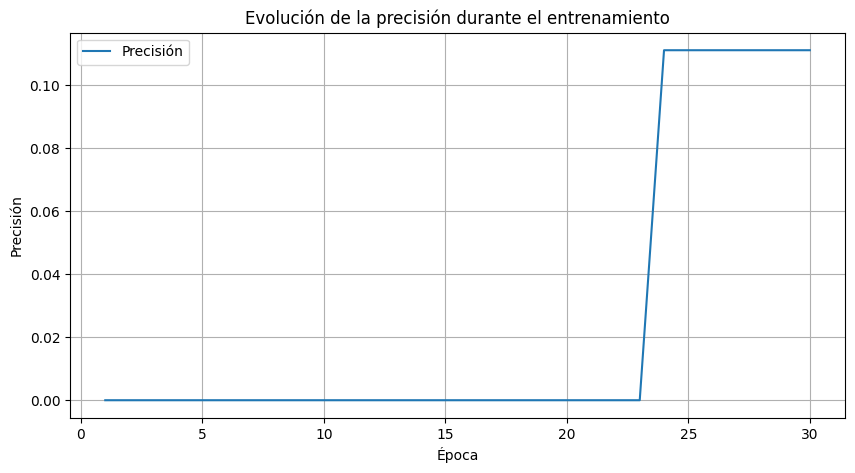

Precisión final del modelo: 0.4444
F1-Score final del modelo: 0.2929


<ipython-input-5-fde645624655>:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Cargar los datos y preprocesamiento
data = pd.read_csv('dataset_elpino.csv', sep=';')

# Función para extraer código antes del guion
def extract_code(value):
    if isinstance(value, str) and '-' in value:
        return value.split('-')[0].strip()
    return value

data.replace('-', pd.NA, inplace=True)
data.dropna(inplace=True)

# Aplicar la función de extracción de códigos
data_codigos = data.apply(lambda col: col.map(extract_code))

# Renombrar columnas a nombres descriptivos
nombres_diagnosticos = [f'diagnostico_{i}' for i in range(1, 36)]
nombres_procedimientos = [f'procedimiento_{i}' for i in range(1, 31)]
otras_columnas = ['edad', 'genero', 'GRD']
data_codigos.columns = nombres_diagnosticos + nombres_procedimientos + otras_columnas

# Codificación de diagnósticos y procedimientos como números
le_diagnostico = LabelEncoder()
le_procedimiento = LabelEncoder()
le_grd = LabelEncoder()

for col in nombres_diagnosticos:
    data_codigos[col] = le_diagnostico.fit_transform(data_codigos[col])

for col in nombres_procedimientos:
    data_codigos[col] = le_procedimiento.fit_transform(data_codigos[col])

# Codificación de la columna GRD
data_codigos['GRD'] = le_grd.fit_transform(data_codigos['GRD'])

# Normalizar las columnas de edad
scaler = StandardScaler()
data_codigos['edad'] = scaler.fit_transform(data_codigos[['edad']])

# Crear secuencias de entrada y etiquetas
secuencias = data_codigos[nombres_diagnosticos + nombres_procedimientos].values
etiquetas = data_codigos['GRD'].values

# Balanceo de clases
grd_distribution = data_codigos['GRD'].value_counts()
majority_class_size = 500
data_majority = data_codigos[data_codigos['GRD'].isin(grd_distribution[grd_distribution > majority_class_size].index)]
data_minority = data_codigos[data_codigos['GRD'].isin(grd_distribution[grd_distribution <= majority_class_size].index)]

# Submuestreo de las clases mayoritarias
data_majority_balanced = data_majority.groupby('GRD', group_keys=False).apply(lambda x: x.sample(majority_class_size))
data_balanced = pd.concat([data_majority_balanced, data_minority])

# Actualizar secuencias y etiquetas con los datos balanceados
secuencias = data_balanced[nombres_diagnosticos + nombres_procedimientos].values
etiquetas = data_balanced['GRD'].values

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(secuencias, etiquetas, test_size=0.3, random_state=42)

# Dataset y DataLoader
class GRDDataset(Dataset):
    def __init__(self, secuencias, etiquetas):
        self.secuencias = secuencias
        self.etiquetas = etiquetas

    def __len__(self):
        return len(self.secuencias)

    def __getitem__(self, idx):
        secuencia = torch.tensor(self.secuencias[idx], dtype=torch.long)
        etiqueta = torch.tensor(self.etiquetas[idx], dtype=torch.long)
        return secuencia, etiqueta

train_dataset = GRDDataset(X_train, y_train)
test_dataset = GRDDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modelo LSTM
class GRDLSTM(nn.Module):
    def __init__(self, vocab_size_diagnostico, vocab_size_procedimiento, emb_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(GRDLSTM, self).__init__()
        self.diagnostico_embedding = nn.Embedding(vocab_size_diagnostico, emb_dim)
        self.procedimiento_embedding = nn.Embedding(vocab_size_procedimiento, emb_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        diag_input = x[:, :35]
        proc_input = x[:, 35:]

        diag_embedded = self.diagnostico_embedding(diag_input)
        proc_embedded = self.procedimiento_embedding(proc_input)

        embedded = torch.cat((diag_embedded, proc_embedded), dim=1)
        lstm_out, (hn, cn) = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]

        lstm_out = self.dropout(self.relu(self.bn1(self.fc1(lstm_out))))
        lstm_out = self.dropout(self.relu(self.bn2(self.fc2(lstm_out))))
        output = self.fc3(lstm_out)
        return output

# Crear el modelo
model = GRDLSTM(vocab_size_diagnostico, vocab_size_procedimiento, emb_dim=128, hidden_dim=256, num_layers=2, num_classes=len(le_grd.classes_), dropout=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 30
losses = []
f1_scores = []
accuracy_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        secuencias, etiquetas = batch
        secuencias, etiquetas = secuencias.to(device), etiquetas.to(device)

        optimizer.zero_grad()
        outputs = model(secuencias)
        loss = loss_fn(outputs, etiquetas)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss / len(train_dataloader))  # Guardar la pérdida por época

    # Evaluación
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_dataloader:
            secuencias, etiquetas = batch
            secuencias, etiquetas = secuencias.to(device), etiquetas.to(device)
            outputs = model(secuencias)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(etiquetas.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calcular métricas
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# Visualización de las métricas

# Pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, label='Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

# F1-Score durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), f1_scores, label='F1-Score')
plt.xlabel('Época')
plt.ylabel('F1-Score')
plt.title('Evolución del F1-Score durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

# Precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracy_scores, label='Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

# Cargar el mejor modelo guardado después del entrenamiento
model.load_state_dict(torch.load('best_model.pth'))

# Evaluación final del mejor modelo
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        secuencias, etiquetas = batch
        secuencias, etiquetas = secuencias.to(device), etiquetas.to(device)
        outputs = model(secuencias)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(etiquetas.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular la precisión final y el F1-score ponderado
accuracy_final = accuracy_score(y_true, y_pred)
f1_final = f1_score(y_true, y_pred, average='weighted')
print(f'Precisión final del modelo: {accuracy_final:.4f}')
print(f'F1-Score final del modelo: {f1_final:.4f}')

Las 10 clases de GRD más frecuentes son:
GRD
1     8
0     8
2     3
6     2
8     1
9     1
5     1
10    1
7     1
4     1
Name: count, dtype: int64
El total de clases en GRD es: 11


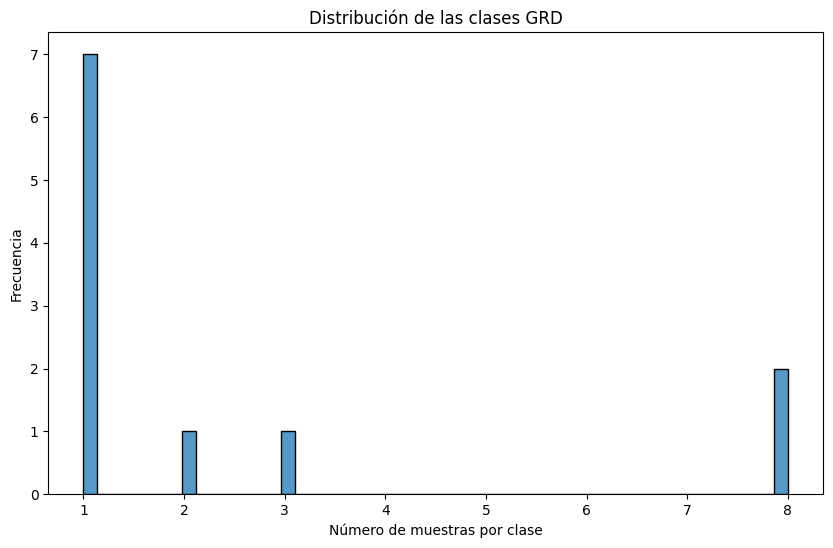

Nueva distribución de clases después del balanceo:
GRD
1     8
0     8
8     8
9     8
5     8
10    8
7     8
4     8
2     8
3     8
Name: count, dtype: int64


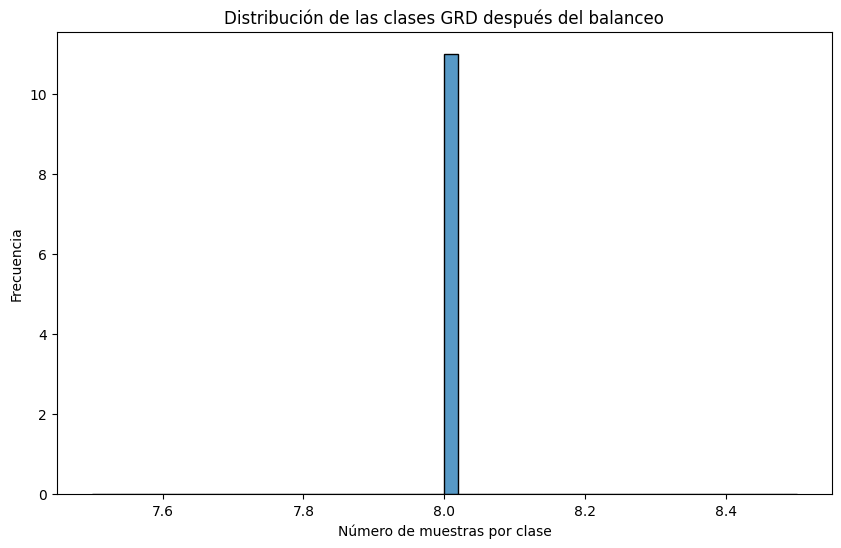

Tamaño del conjunto de entrenamiento: 61
Tamaño del conjunto de prueba: 27


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Cargar los datos
data = pd.read_csv('dataset_elpino.csv', sep=';')

# Función para extraer el código antes del guion
def extract_code(value):
    if isinstance(value, str) and '-' in value:
        return value.split('-')[0].strip()
    return value

# Reemplazar los guiones y valores nulos por NaN, luego eliminar filas con NaN
data.replace('-', pd.NA, inplace=True)
data.dropna(inplace=True)

# Aplicar la función a todas las columnas del DataFrame
data_codigos = data.apply(lambda col: col.map(extract_code))

# Codificar los diagnósticos y procedimientos
nombres_diagnosticos = [f'diagnostico_{i}' for i in range(1, 36)]
nombres_procedimientos = [f'procedimiento_{i}' for i in range(1, 31)]
otras_columnas = ['edad', 'genero', 'GRD']

# Mapeo de nombres de columnas
data_codigos.columns = nombres_diagnosticos + nombres_procedimientos + otras_columnas

# Codificación de GRD y otros valores categóricos
le_grd = LabelEncoder()
data_codigos['GRD'] = le_grd.fit_transform(data_codigos['GRD'])

# Verificar la distribución de las clases GRD
grd_distribution = data_codigos['GRD'].value_counts()

# Mostrar los 10 GRD más frecuentes
print("Las 10 clases de GRD más frecuentes son:")
print(grd_distribution.head(10))
print(f"El total de clases en GRD es: {len(grd_distribution)}")

# Graficar la distribución de clases GRD
plt.figure(figsize=(10, 6))
sns.histplot(grd_distribution, bins=50, kde=False)
plt.title('Distribución de las clases GRD')
plt.xlabel('Número de muestras por clase')
plt.ylabel('Frecuencia')
plt.show()

# Estrategia de balanceo de clases: Submuestreo o sobremuestreo
X = data_codigos[nombres_diagnosticos + nombres_procedimientos + ['edad', 'genero']]
y = data_codigos['GRD']

# Sobremuestreo para balancear las clases
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Mostrar la nueva distribución de clases después del balanceo
new_grd_distribution = pd.Series(y_resampled).value_counts()

print("Nueva distribución de clases después del balanceo:")
print(new_grd_distribution.head(10))

# Graficar la nueva distribución de clases
plt.figure(figsize=(10, 6))
sns.histplot(new_grd_distribution, bins=50, kde=False)
plt.title('Distribución de las clases GRD después del balanceo')
plt.xlabel('Número de muestras por clase')
plt.ylabel('Frecuencia')
plt.show()

# Dividir los datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Mostrar tamaño del conjunto de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")